In [3]:
# Importation des librairies
import sys
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [ ]:
# Extraction des fichiers de données
!unzip test.zip -d /content/input
!unzip train.zip -d /content/input

In [4]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

## Chargement des données
On crée une fonction "load_data" pour charger les images et les labels correspondants à partir des dossiers de données.

In [5]:
def load_data():
    """
        Chargement des données:
            - 14,034 images pour entrainer notre réseau.
            - 3,000 images pour évaluer comment notre réseau a été entraîner.
    """
    
    datasets = ['./input/seg_train', './input/seg_test']
    output = []
    
    # Itération du dataset à travers les jeux de données train et test
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Itération à travers chaque dossier qui correspond à chaque catégorie
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Itération à travers chaque image dans le dossier
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Récupération du nom du chemin de l'image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Ouverture et redimensionnement de l'image
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Ajout de l'image et de son label correspondant à notre output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ./input/seg_train


100%|██████████| 2382/2382 [00:23<00:00, 101.19it/s]


Loading ./input/seg_test


100%|██████████| 501/501 [00:04<00:00, 103.27it/s]


In [17]:
# Mélange des données 
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

## Exploration du dataset

In [19]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Nombre d'exemples de training: {}".format(n_train))
print ("Nombre d'exemples de test: {}".format(n_test))
print ("Chaque image est de taille: {}".format(IMAGE_SIZE))

Nombre d'exemples de training: 14034
Nombre d'exemples de test: 3000
Chaque image est de taille: (150, 150)


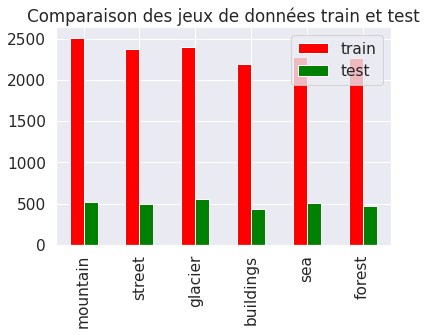

In [22]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar(color=['red', 'green'])
plt.title("Comparaison des jeux de données train et test")
plt.show()

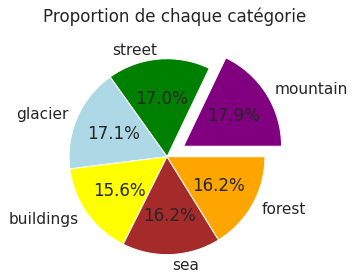

In [33]:
plt.pie(train_counts,
        explode=(0.2, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%',
        colors=['purple', 'green','lightblue','yellow','brown','orange'])
plt.axis('equal')
plt.title('Proportion de chaque catégorie\n')
plt.show()

On va mettre à l'échelle nos données pour éviter des résultats avec des valeures absurdes à cause de grandes variations.

In [34]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

On affiche les 25 premières images de notre jeu de données train avec leurs labels correspondants.

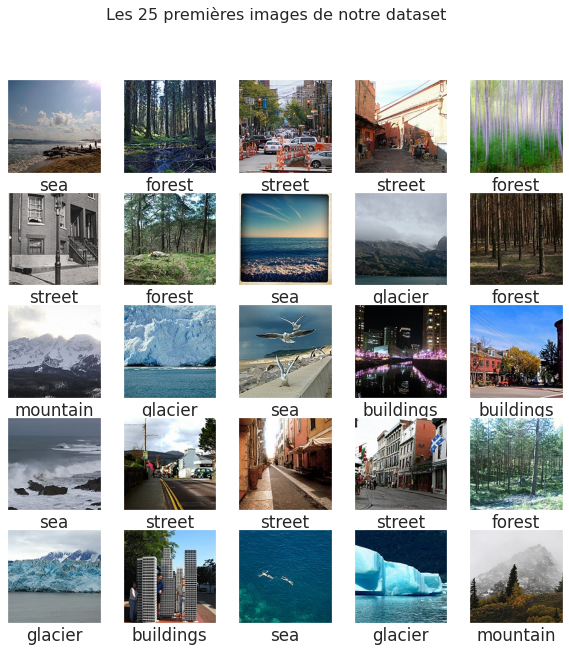

In [38]:
#Affichage des 25 premières images de notre jeu de données train avec leurs labels correspondants
def display_examples(class_names, images, labels):
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Les 25 premières images de notre dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
display_examples(class_names, train_images, train_labels)

## Première partie: Création d'un premier modèle simple.
On suit l'ordre suivant: 

1.   On consruit le modèle
2.   On compile le modèle
3.   On entraîne le modèle avec la fonction "fit"
4.   On évalue le modèle avec le jeu de données test à l'aide de la fonction "evaluate"
5.   On analyse si notre modèle présente une erreur

Notre premier modèle simple se compose des couches suivantes:


*   Élément de liste
*   Élément de liste

